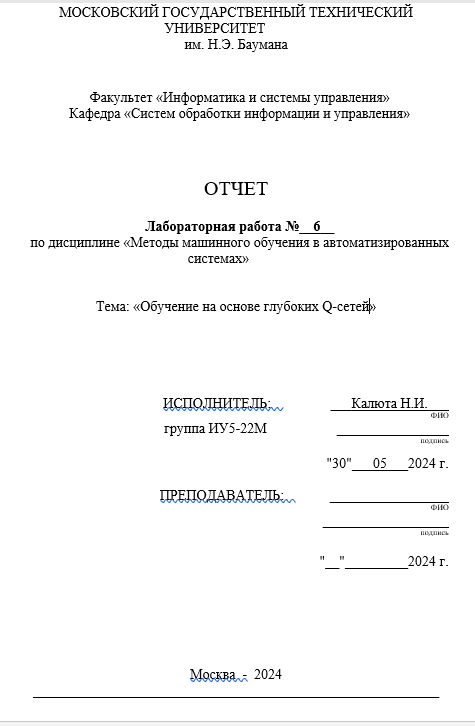

###**Цель лабораторной работы:**
Ознакомление с базовыми методами обучения с подкреплением на основе глубоких Q-сетей.

###**Задание:**

* На основе рассмотренных на лекции примеров реализуйте алгоритм DQN.
* В качестве среды можно использовать классические среды (в этом случае используется полносвязная архитектура нейронной сети).
* В качестве среды можно использовать игры Atari (в этом случае используется сверточная архитектура нейронной сети).

# Ход выполнения задания

## Установка зависимостей

Установка необходимых библиотек и зависимостей для работы с Atari-играми

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!apt-get update > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

!pip install swig==4.1.1
!pip install Box2D==2.3.2
!pip install box2d-kengz==2.3.3
!pip install pygame==2.2.0
!pip install ale_py==0.8.1
!pip install pyglet==1.5.11


!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install --upgrade AutoROM
!AutoROM --accept-license
!pip install gymnasium[atari]==0.28.1

!wget http://www.atarimania.com/roms/Roms.rar
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul

!pip install pyvirtualdisplay > /dev/null 2>&1

!pip install --upgrade gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 6.4 MB/s eta 0:00:00


Установка библиотек, необходимые для работы с графикой и видео

In [ ]:
!apt-get install xvfb
!apt-get install python3-opengl ffmpeg

Создать папку с названием "video"

In [ ]:
!mkdir -p video

## Импорт библиотек

In [ ]:
import gymnasium as gym
from gymnasium import logger as gymlogger
from gymnasium.wrappers.record_video import RecordVideo

gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from tqdm import tqdm
import math
import uuid
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Дополнительные функции

Функции для работы с видеозаписями, создает среду Gym с возможностью записи видео и выводит информацию о среде

In [ ]:
def show_video(folder_name):
  mp4list = glob.glob(f'{folder_name}/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env, folder_name):
  env = RecordVideo(env, folder_name, step_trigger = lambda episode_number: True)
  return env

def create_environment(name):
    folder_name = f"./video/{name}/{uuid.uuid4()}"
    env = wrap_env(gym.make(name, render_mode="rgb_array"), folder_name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")
    return env, folder_name

Создает невидимый виртуальный дисплей размером 1400x900 пикселей

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

## Создание агента

Реализация алгоритма обучения с подкреплением Deep Q-Network (DQN) с использованием PyTorch.

In [ ]:
# Использование GPU
CONST_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Элемент ReplayMemory в форме именованного кортежа
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Реализация техники Replay Memory
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        '''
        Сохранение данных в ReplayMemory
        '''
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        '''
        Выборка случайных элементов размера batch_size
        '''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN_Model(nn.Module):

    def __init__(self, n_observations, n_actions):
        '''
        Инициализация топологии нейронной сети
        '''
        super(DQN_Model, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        '''
        Прямой проход
        Вызывается для одного элемента, чтобы определить следующее действие
        Или для batch'а во время процедуры оптимизации
        '''
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


class DQN_Agent:

    def __init__(self, env,
                 BATCH_SIZE = 128,
                 GAMMA = 0.99,
                 EPS_START = 0.9,
                 EPS_END = 0.05,
                 EPS_DECAY = 1000,
                 TAU = 0.005,
                 LR = 1e-4
                 ):
        # Среда
        self.env = env
        # Размерности Q-модели
        self.n_actions = env.action_space.n
        state, _ = self.env.reset()
        self.n_observations = len(state)
        # Коэффициенты
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.TAU = TAU
        self.LR = LR
        # Модели
        # Основная модель
        self.policy_net = DQN_Model(self.n_observations, self.n_actions).to(CONST_DEVICE)
        # Вспомогательная модель, используется для стабилизации алгоритма
        # Обновление контролируется гиперпараметром TAU
        # Используется подход Double DQN
        self.target_net = DQN_Model(self.n_observations, self.n_actions).to(CONST_DEVICE)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        # Оптимизатор
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        # Replay Memory
        self.memory = ReplayMemory(10000)
        # Количество шагов
        self.steps_done = 0
        # Длительность эпизодов
        self.episode_durations = []


    def select_action(self, state):
        '''
        Выбор действия
        '''
        sample = random.random()
        eps = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps:
            with torch.no_grad():
                # Если вероятность больше eps
                # то выбирается действие, соответствующее максимальному Q-значению
                # t.max(1) возвращает максимальное значение колонки для каждой строки
                # [1] возвращает индекс максимального элемента
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            # Если вероятность меньше eps
            # то выбирается случайное действие
            return torch.tensor([[self.env.action_space.sample()]], device=CONST_DEVICE, dtype=torch.long)


    def plot_durations(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Результат')
        else:
            plt.clf()
            plt.title('Обучение...')
        plt.xlabel('Эпизод')
        plt.ylabel('Количество шагов в эпизоде')
        plt.plot(durations_t.numpy())
        plt.pause(0.001)  # пауза


    def optimize_model(self):
        '''
        Оптимизация модели
        '''
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Транспонирование batch'а
        # (https://stackoverflow.com/a/19343/3343043)
        # Конвертация batch-массива из Transition
        # в Transition batch-массивов.
        batch = Transition(*zip(*transitions))

        # Вычисление маски нефинальных состояний и конкатенация элементов batch'а
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=CONST_DEVICE, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Вычисление Q(s_t, a)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Вычисление V(s_{t+1}) для всех следующих состояний
        next_state_values = torch.zeros(self.BATCH_SIZE, device=CONST_DEVICE)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Вычисление ожидаемых значений Q
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Вычисление Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Оптимизация модели
        self.optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()


    def play_agent(self):
        '''
        Проигрывание сессии для обученного агента
        '''
        env2, folder = create_environment("CartPole-v1")
        state = env2.reset()[0]
        state = torch.tensor(state, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)
        done = False
        res = []
        while not done:

            action = self.select_action(state)
            action = action.item()
            observation, reward, terminated, truncated, _ = env2.step(action)
            env2.render()

            res.append((action, reward))

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)

            state = next_state
            if terminated or truncated:
                done = True

        print('Данные об эпизоде: ', res)
        env2.close()
        show_video(folder)


    def learn(self):
        '''
        Обучение агента
        '''
        if torch.cuda.is_available():
            num_episodes = 500
        else:
            num_episodes = 50

        for i_episode in range(num_episodes):
            # Инициализация среды
            state, info = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)
            for t in count():
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=CONST_DEVICE)

                done = terminated or truncated
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)

                # Сохранение данных в Replay Memory
                self.memory.push(state, action, next_state, reward)

                # Переход к следующему состоянию
                state = next_state

                # Выполнение одного шага оптимизации модели
                self.optimize_model()

                # Обновление весов target-сети
                # θ′ ← τ θ + (1 − τ )θ′
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    self.episode_durations.append(t + 1)
                    self.plot_durations()
                    break


Обучение агента DQN, чтобы он мог играть в игру CartPole-v1, используя библиотеку Gym.

In [ ]:
env = gym.make("CartPole-v1")
agent = DQN_Agent(env)
agent.learn()
agent.play_agent()

Проверяем, насколько хорошо обучен агент DQN и как он играет в CartPole-v1.

In [ ]:
agent.play_agent()

##Вывод
В ходе выполнения лабораторной работы познакомился с  Deep Q-Learning (DQN) -  алгоритмом  обучения  агентов  для  игр. Реализовал нейронную сеть DQN,  использовали Replay Memory и Double DQN для  стабилизации  обучения,  а  также  применили  оптимизатор AdamW. В результате смог обучить  агента,  способного  играть  в  CartPole-v1.